Borrowed from Dr.Chandola's notebook on Gaussian Process Optimization 

In [15]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
from scipy.stats import zscore,invwishart,dirichlet,multinomial,norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma
sns.set(color_codes=True)
sns_c = sns.color_palette(palette='deep')
sns.set_style('whitegrid')
sns.set_context('paper',font_scale=2)
from mpl_toolkits import mplot3d
import plotly.graph_objects as go
%matplotlib inline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.datasets import load_boston
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import Lasso 
from sklearn.datasets import load_breast_cancer

In [16]:
def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()


In [17]:

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    #plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    
        


In [18]:
def cancer(gamma):
    
    #Sklearns Breast Cancer dataset
    X, y = load_breast_cancer(return_X_y=True)
    np.ceil(0.8*len(X))
    x_train=X[:90,:]
    x_test=X[90:,:]
    y_train=y[:90]
    y_test=y[90:]
    model=SVC(C=gamma)
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    op=np.mean(y_pred==y_test)
    
    #line of code to make the function have two maxima
    if gamma > 0.4 and gamma < 0.8:
        op=op-gamma*0.1
    return op*10
    

In [19]:
x=np.linspace(0.15,1,100)

In [20]:
y=[]
for i in x:
    y.append(cancer(i))
index=np.argmax(y)


bounds = np.array([[0.15, 1]])
X_init=0.1

Y_init=np.array([[cancer(X_init)]])
X_init=np.array([[X_init]])


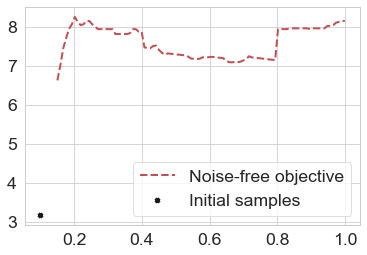

In [21]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
#Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(x, y, 'r--', lw=2, label='Noise-free objective')
#plt.plot(Y, X, 'bx', lw=1, alpha=0.75, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

In [22]:
from scipy.stats import norm

def expected_improvement(X, X_sample, Y_sample, gpr, xi=1):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    #return (norm.cdf(Z)).flatten()        
    return ei.flatten()

In [23]:
from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

In [24]:
def min_obj(X):
    # Minimization objective is the negative acquisition function
    return -expected_improvement(X.reshape(-1, dim), X_sample, Y_sample, gpr)

 C:\Users\shath\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning:lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


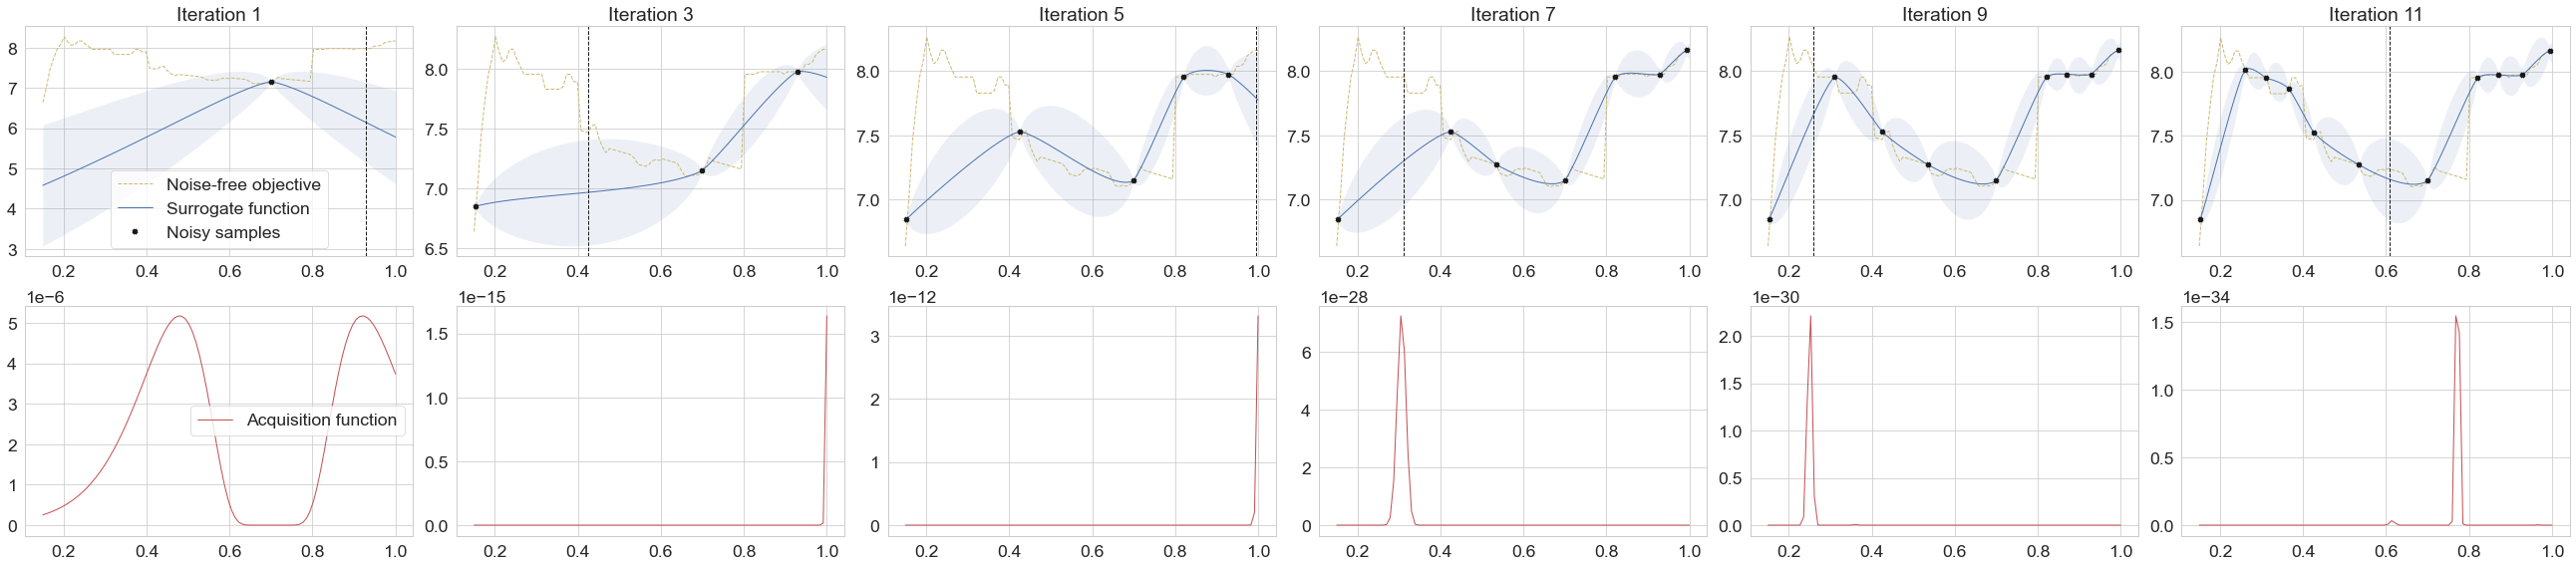

In [27]:
bounds = np.array([[0.15, 1]])
X_init=0.7

Y_init=np.array([[cancer(X_init)]])
X_init=np.array([[X_init]])
# Gaussian process with Matern kernel as surrogate model
m52_sin = ConstantKernel(50) * Matern(length_scale=1, nu=0.7)+ExpSineSquared(length_scale=1, periodicity=0.2)
m52 = Matern(length_scale=1, nu=0.7)
kernel = ConstantKernel(0)+ExpSineSquared(length_scale=1, periodicity=0.2)
gpr = GaussianProcessRegressor(kernel=m52, alpha=0)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 12

plt.figure(figsize=(n_iter * 3,8))
#plt.subplots_adjust(hspace=0.2)

val_max=float('-inf')
arg_max=float('-inf')
for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = cancer(X_next)
    if Y_next>val_max:
        val_max=Y_next
        arg_max=X_next
    
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    if i%2==0:
        plt.subplot(2, n_iter/2, i/2+1)
        plot_approximation(gpr, np.array(x).reshape(-1,1),np.array(y).reshape(-1,1), X_sample, Y_sample, X_next, show_legend=i==0)
        #plot_approximation(gpr, X,Y, X_sample, Y_sample, X_next, show_legend=i==0)
        plt.title(f'Iteration {i+1}')

        plt.subplot(2, n_iter/2, (n_iter + i )/2+1)
        plot_acquisition(x, expected_improvement(np.array(x).reshape(-1,1), X_sample, Y_sample, gpr), X_next, show_legend=i==0)
        #plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))
plt.tight_layout()


In [28]:
arg_max,val_max

(array([[0.99441691]]), 8.162839248434238)